### 1. Importing necessary libraries

In [1]:
import sys
sys.path.append('surface_crack_detection')
from utils.utils import split_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-09-28 15:23:19.402250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-28 15:23:19.402274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 2. Loading the dataset

In [2]:
# load dataset
dataset = pd.read_csv('dataset/dataset_final.csv')

### 3. Splitting training, validation and testing data

First, we split the dataset into a list containing training and testing data. Then, we obtain the training, validation, and testing data.

In [3]:
# split dataset
train_df, test_df = train_test_split(dataset.sample(frac=1.0, random_state=42), test_size=0.80, random_state=42)

# train, validation and test data
train_data, valid_data, test_data = split_data(train_df, test_df)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


### 4. Using InceptionV3 architecture

In [4]:
# using this class at the end of an epoch
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.999):
            self.model.stop_training = True
            
callbacks = myCallback()

**InceptionV3** is a convolutional neural network (CNN) used as image recognation model. This model includes convolutions, average pooling, max pooling, concatenations, dropouts and fully connected layers. Also, the batch normalization is very used troughout the model and applied to activation inputs. Loss is computed using Softmax.

In [5]:
# load the path to weights file
load_weights_file = 'surface_crack_detection/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# using the inceptionV3 architecture
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, input_shape=(227, 227, 3), weights=load_weights_file)

# making all the layers in base_model non-trainable
for layer in base_model.layers:
    layer.trainable = False

# using the part of base_model from input later until the layer 'mixed7'
last_layer = base_model.get_layer('mixed7')
last_output = last_layer.output

2023-09-28 15:23:21.257280: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-09-28 15:23:21.257310: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cilab-local): /proc/driver/nvidia/version does not exist
2023-09-28 15:23:21.257513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 5. Building the model

In [6]:
# building the model
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(base_model.input, x)

# compiling the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

# showing model's summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### 6. Training the model

In [7]:
# training the model
history = model.fit(train_data, validation_data=valid_data,
                    epochs=7, verbose=1, callbacks=[callbacks])

Epoch 1/7


200/200 [==============================] - 152s 750ms/step - loss: 0.0942 - accuracy: 0.9841 - val_loss: 0.0092 - val_accuracy: 0.9981
Epoch 2/7
200/200 [==============================] - 148s 740ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0068 - val_accuracy: 0.9969
Epoch 3/7
200/200 [==============================] - 148s 742ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0055 - val_accuracy: 0.9981


### 7. Checking the model's accuracy

In [8]:
test_loss, test_acc = model.evaluate(test_data)

print('\nAcurácia do modelo: {:.2f}%'.format(test_acc*100))
print('\nPerda do modelo: {:.2f}'.format(test_loss*100))

1000/1000 [==============================] - 344s 344ms/step - loss: 0.0164 - accuracy: 0.9977

Acurácia do modelo: 99.77%

Perda do modelo: 1.64


### 8. Making predictions

1000/1000 [==============================] - 346s 346ms/step


Text(0.5, 1.0, 'Confusion matrix')

<Figure size 600x600 with 0 Axes>

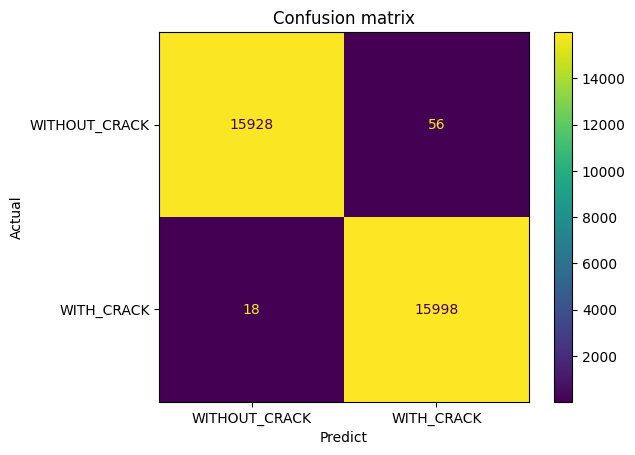

In [9]:
y_pred = np.squeeze(model.predict(test_data) >= 0.5).astype(np.int32)

cm = confusion_matrix(test_data.labels, y_pred)
disp = ConfusionMatrixDisplay(cm)

plt.figure(figsize=(6,6))
disp.plot()
plt.xticks(ticks=np.arange(2), labels=['WITHOUT_CRACK', 'WITH_CRACK'])
plt.yticks(ticks=np.arange(2), labels=['WITHOUT_CRACK', 'WITH_CRACK'])
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion matrix')

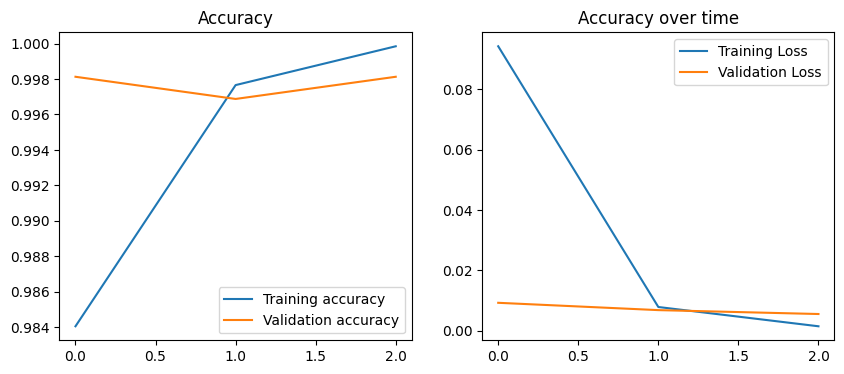

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

plt.subplot(1,2,2)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Accuracy over time')
plt.legend(["Training Loss", "Validation Loss"])

plt.show()